# Metrics and Results

This notebook loads existing kit features/metrics and processes new features and metrics to get tiering data on relevant analytical, cost, time, etc features for each kit. It provides useful visualizations for the tiering performed both in this notebook and in others. 

**This notebook cannot be run with the existing data in this repo. It serves as an example of how the data was processed for our paper**

In [43]:
##Import necessary packages
import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
from scipy.signal import find_peaks
from scipy.stats import gaussian_kde
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

In [44]:
##generic plotting parameters for paper
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams.update({'font.size': 10})
mpl.rcParams["font.family"] = "arial"

##plotting order by type
plotting_order = ['10X_3-rep1', '10X_3-rep2','10X_5-rep1', '10X_5-rep2', '10X_FRP-rep1','10X_FRP-rep2','Fluent-rep1', 'Fluent-rep2', 'Fluent-rep3', ##droplet
                  'BD-rep1', 'BD-rep2', 'Honeycomb-rep1','Honeycomb-rep2', ##well-based
                  'Parse-rep2','Scale-rep1', ##combinatorial
                  'Scipio-rep1', 'Scipio-rep2' ] ##matrigel

In [45]:
parent_dir=##INSERT HERE
figure_dir=##INSERT HERE
supplement_dir=os.path.join(figure_dir, 'supplement')
supplement_fig_dir=os.path.join(supplement_dir, 'figures')
supplement_table_dir=os.path.join(supplement_dir, 'tables')

##make figure directories if they doesn't exist
os.makedirs(figure_dir, exist_ok=True)
os.makedirs(supplement_fig_dir, exist_ok=True)
os.makedirs(supplement_table_dir, exist_ok=True)

In [46]:
##directory for summary metrics
summary_metric_dir = os.path.join(parent_dir, 'summary_metrics')
summary_metric_file = os.path.join(summary_metric_dir, 'Results_Summary_Graph_Metrics_Singleron_Removed.csv')
summary_df = pd.read_csv(summary_metric_file)
summary_df

,kit,fixation,nuclei,FFPE,cost_per_cell,equipment_cost,time,maximum_cell_recovery,cell_recovery_tier,gene_saturation_tier,umi_saturation_tier,read_utilization_tier,gene_umi_count_tier,mt_fraction_tier,rp_fraction_tier,gene_stability_tier,celltype_dist_tier,cluster_discrim_tier,diff_expr_tier
0,10X_3,False,True,False,0.16,65000,8.500000,10000,1,2,1,2,1,2,2.0,1,1,1,1
1,10X_5,False,True,False,0.16,65000,7.500000,10000,1,2,2,3,2,2,2.0,1,1,1,2
2,10X_FRP,True,True,True,0.17,65000,24.500000,10000,1,1,1,1,1,1,NaN,1,1,1,1
3,Fluent,False,True,False,0.05,3000,14.500000,20000,1,3,2,3,2,2,2.0,2,3,1,2
4,BD,False,True,False,0.08,11000,7.833333,20000,2,2,1,2,1,3,2.0,1,1,1,2
5,Honeycomb,False,True,False,0.11,2000,10.500000,17000,1,3,2,3,2,2,2.0,2,2,2,3
6,Parse,True,True,False,0.11,0,19.000000,140000,2,2,2,3,2,1,1.0,1,1,2,2
7,Scale,True,True,False,0.09,0,10.333333,153600,1,2,2,3,2,1,1.0,2,1,2,2
8,Scipio,False,False,False,0.21,0,11.333333,5000,1,3,2,3,2,2,2.0,3,2,2,3


Let's break up some of the numerical columns into tiers so that we can score by category

First cost per cell

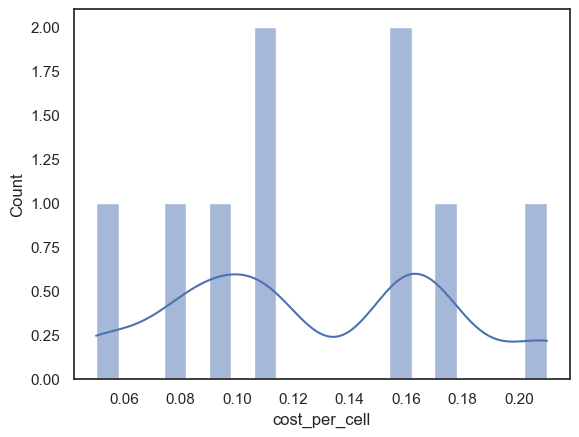

In [47]:
sns.set(style='white')

##first group by platform, get mean, and sort by ascending value
cost_per_cell = summary_df[['kit', 'cost_per_cell']]
cost_per_cell = cost_per_cell.groupby('kit')['cost_per_cell'].mean().sort_values(ascending=True)

##plot histogram with a kde on top
fig, ax = plt.subplots(1,1)
sns.histplot(cost_per_cell, bins=20, kde=True, kde_kws={'bw_method':0.3}, ax=ax)
plt.show()

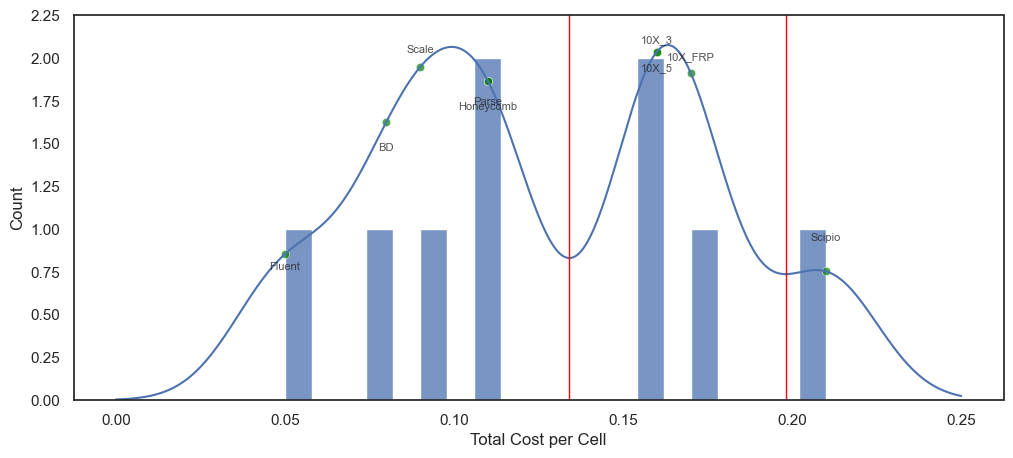

In [48]:
##fit kernel density estimator
bw_method=0.3 ##manually selected to give relatively smooth curve
X_range = np.linspace(0,0.25, 1000) #X values on range of 0 to 0.25 based on histogram above
kernel = gaussian_kde(cost_per_cell, bw_method=bw_method, weights=None) #define kde with bw_method
fitted_dens = kernel.evaluate(X_range) #get density
predicted_dens = kernel.evaluate(cost_per_cell)
ordered_labels = cost_per_cell.index

##scale density to get onto scale of histogram
fitted_dens = fitted_dens *0.25
predicted_dens = predicted_dens*0.25

 ##Calculate the negative density values so we can find minima by finding peaks of the negative density
neg_dens = -fitted_dens

##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
with ignore_warnings(category=ConvergenceWarning):
    minima_indices, _ = find_peaks(neg_dens)

##get thresholds
cost_per_cell_thresholds = X_range[minima_indices]

##plot split with points and thresholds
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(X_range, fitted_dens)
sns.histplot(cost_per_cell, bins=20, ax=ax)
sns.scatterplot(x=cost_per_cell, y=predicted_dens, color='green',  alpha=0.7, ax=ax)

##Add threshold lines
[ax.axvline(_x, linewidth=1, color="red", linestyle="-") for _x in cost_per_cell_thresholds]

##Adding labels

np.random.seed(41)
y_jitter = (np.random.rand(len(cost_per_cell))-0.5)/2.5  # get jitter in range 
for i, txt in enumerate(ordered_labels):
    ax.annotate(txt, ((cost_per_cell[i]), (predicted_dens[i]+y_jitter[i])), alpha=0.8, ha='center', va='bottom', fontsize=8) ##add vertical jitter
    
##Format Axes
ax.set_xlabel('Total Cost per Cell')
ax.set_ylim([None, 2.25])
    
plt.show()

In [49]:
##get groups now that we have thresholds (lower group if <= higher group if >)
cost_per_cell_thresholds = np.sort(cost_per_cell_thresholds) ##make sure it is ascending so first is lower one
cost_per_cell_tiers = { 
    3: cost_per_cell[cost_per_cell > cost_per_cell_thresholds[1]].index.to_list(),
    2: cost_per_cell[(cost_per_cell > cost_per_cell_thresholds[0]) & (cost_per_cell <= cost_per_cell_thresholds[1])].index.to_list(),
    1: cost_per_cell[cost_per_cell <= cost_per_cell_thresholds[0]].index.to_list()
}
print('Cost per Cell Tiers:')
cost_per_cell_dict = {}
for k, v in cost_per_cell_tiers.items():
    for value in v:
        cost_per_cell_dict[value] = k
    
cost_per_cell_dict

Cost per Cell Tiers:


{'Scipio': 3,
 '10X_3': 2,
 '10X_5': 2,
 '10X_FRP': 2,
 'Fluent': 1,
 'BD': 1,
 'Scale': 1,
 'Honeycomb': 1,
 'Parse': 1}

This tiering essentially breaks costs into cheapest (around \\$0.05 per cell), moderate (around \\$0.10 per cell), and expensive (more than $0.15 per cell)

Now Equipment Costs (doing log scale since they vary so much)

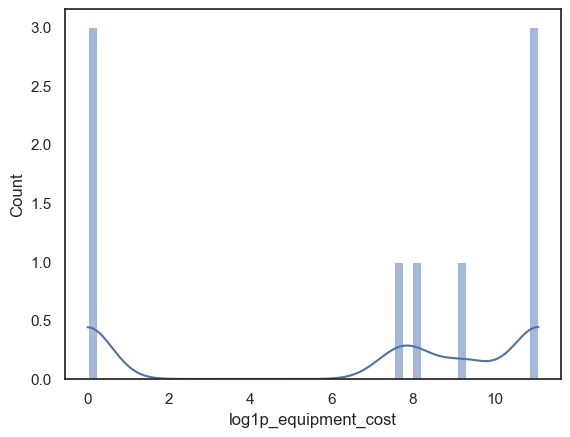

In [50]:
sns.set(style='white')

##first group by platform, get mean, and sort by ascending value
equipment_cost = summary_df[['kit', 'equipment_cost']]
log1p_equipment_cost = np.log1p(equipment_cost.groupby('kit')['equipment_cost'].mean().sort_values(ascending=True))
log1p_equipment_cost.name='log1p_equipment_cost'

#plot histogram with a kde on top
fig, ax = plt.subplots(1,1)
sns.histplot(log1p_equipment_cost, bins=50, kde=True, kde_kws={'bw_method':0.12}, ax=ax)
plt.show()

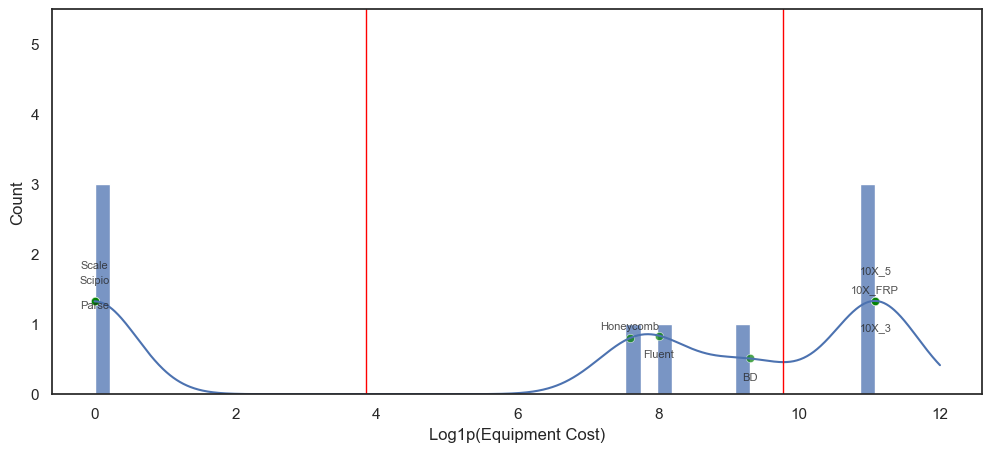

In [51]:
##fit kernel density estimator
bw_method=0.12 ##manually selected to give relatively smooth curve
X_range = np.linspace(0,12,1000) #X values on range of 0 to 12 based on histogram above
kernel = gaussian_kde(log1p_equipment_cost, bw_method=bw_method, weights=None) #define kde with bw_method
fitted_dens = kernel.evaluate(X_range) #get density
predicted_dens = kernel.evaluate(log1p_equipment_cost)
ordered_labels = log1p_equipment_cost.index

##scale density to get onto scale of histogram
fitted_dens = fitted_dens *6
predicted_dens = predicted_dens*6

 ##Calculate the negative density values so we can find minima by finding peaks of the negative density
neg_dens = -fitted_dens

##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
with ignore_warnings(category=ConvergenceWarning):
    minima_indices, _ = find_peaks(neg_dens)

##get thresholds
log1p_equipment_cost_thresholds = X_range[minima_indices]

##plot split with points and thresholds
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(X_range, fitted_dens)
sns.histplot(log1p_equipment_cost, bins=50, ax=ax)
sns.scatterplot(x=log1p_equipment_cost, y=predicted_dens, color='green',  alpha=0.7, ax=ax)

##Add threshold lines
[ax.axvline(_x, linewidth=1, color="red", linestyle="-") for _x in log1p_equipment_cost_thresholds]

##Adding labels

np.random.seed(42)
y_jitter = (np.random.rand(len(log1p_equipment_cost))-0.5)  # get jitter in range 
for i, txt in enumerate(ordered_labels):
    ax.annotate(txt, ((log1p_equipment_cost[i]), (predicted_dens[i]+y_jitter[i])), alpha=0.8, ha='center', va='bottom', fontsize=8) ##add vertical jitter
    
##Format Axes
ax.set_xlabel('Log1p(Equipment Cost)')
ax.set_ylim([None, 5.5])
    
plt.show()

In [52]:
##get groups now that we have thresholds (lower group if <= higher group if >)
log1p_equipment_cost_thresholds = np.sort(log1p_equipment_cost_thresholds) ##make sure it is ascending so first is lower one
log1p_equipment_cost_tiers = { 
    3: log1p_equipment_cost[log1p_equipment_cost > log1p_equipment_cost_thresholds[1]].index.to_list(),
    2: log1p_equipment_cost[(log1p_equipment_cost > log1p_equipment_cost_thresholds[0]) & (log1p_equipment_cost <= log1p_equipment_cost_thresholds[1])].index.to_list(),
    1: log1p_equipment_cost[log1p_equipment_cost <= log1p_equipment_cost_thresholds[0]].index.to_list()
}
print('Equipment Cost Tiers:')
log1p_equipment_cost_dict = {}
for k, v in log1p_equipment_cost_tiers.items():
    for value in v:
        log1p_equipment_cost_dict[value] = k
    
log1p_equipment_cost_dict

Equipment Cost Tiers:


{'10X_3': 3,
 '10X_5': 3,
 '10X_FRP': 3,
 'Honeycomb': 2,
 'Fluent': 2,
 'BD': 2,
 'Parse': 1,
 'Scale': 1,
 'Scipio': 1}

This tiering essentially breaks groups into those with no costs, those with less than \\$15k costs, and those with more than \\$15k costs

Okay, now let's group maximum cell recovery into tiers (again log scale because of the range)

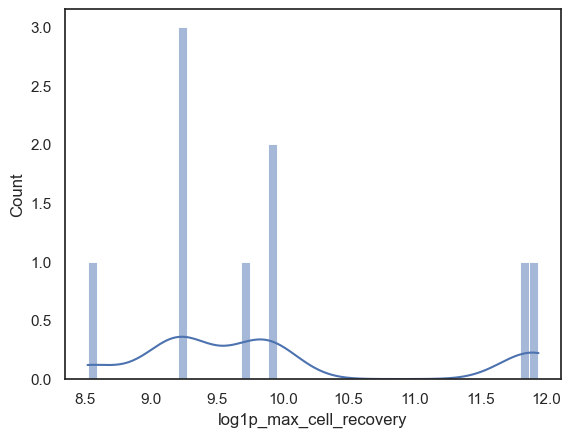

In [53]:
sns.set(style='white')

##first group by platform, get mean, and sort by ascending value
max_cell_recovery = summary_df[['kit', 'maximum_cell_recovery']]
log1p_max_cell_recovery = np.log1p(max_cell_recovery.groupby('kit')['maximum_cell_recovery'].mean().sort_values(ascending=True))
log1p_max_cell_recovery.name='log1p_max_cell_recovery'

#plot histogram with a kde on top
fig, ax = plt.subplots(1,1)
sns.histplot(log1p_max_cell_recovery, bins=50, kde=True, kde_kws={'bw_method':0.2}, ax=ax)
plt.show()

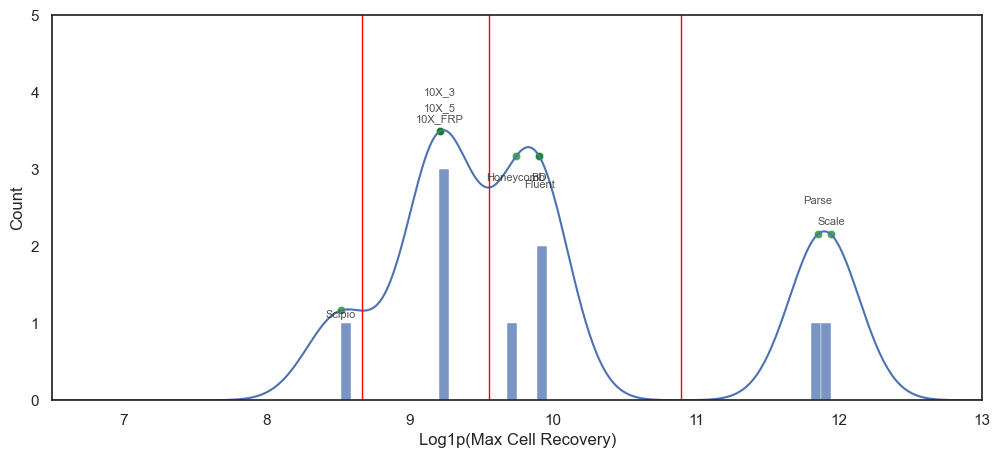

In [54]:
##fit kernel density estimator
bw_method=0.2 ##manually selected to give relatively smooth curve
X_range = np.linspace(0,13,1000) #X values on range of 0 to 12 based on histogram above
kernel = gaussian_kde(log1p_max_cell_recovery, bw_method=bw_method, weights=None) #define kde with bw_method
fitted_dens = kernel.evaluate(X_range) #get density
predicted_dens = kernel.evaluate(log1p_max_cell_recovery)
ordered_labels = log1p_max_cell_recovery.index

##scale density to get onto scale of histogram
fitted_dens = fitted_dens *6
predicted_dens = predicted_dens*6

 ##Calculate the negative density values so we can find minima by finding peaks of the negative density
neg_dens = -fitted_dens

##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
with ignore_warnings(category=ConvergenceWarning):
    minima_indices, _ = find_peaks(neg_dens)

##get thresholds
log1p_max_cell_recovery_thresholds = X_range[minima_indices]

##plot split with points and thresholds
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(X_range, fitted_dens)
sns.histplot(log1p_max_cell_recovery, bins=50, ax=ax)
sns.scatterplot(x=log1p_max_cell_recovery, y=predicted_dens, color='green',  alpha=0.7, ax=ax)

##Add threshold lines
[ax.axvline(_x, linewidth=1, color="red", linestyle="-") for _x in log1p_max_cell_recovery_thresholds]

##Adding labels

np.random.seed(42)
y_jitter = (np.random.rand(len(log1p_max_cell_recovery))-0.5)  # get jitter in range 
for i, txt in enumerate(ordered_labels):
    ax.annotate(txt, ((log1p_max_cell_recovery[i]), (predicted_dens[i]+y_jitter[i])), alpha=0.8, ha='center', va='bottom', fontsize=8) ##add vertical jitter
    
##Format Axes
ax.set_xlabel('Log1p(Max Cell Recovery)')
ax.set_ylim([None, 5])
ax.set_xlim([6.5, 13])
    
plt.show()

We can get 4 tiers out of this; however, we decided to break up the cell recovery into lower than typical range of scRNA experiments (<10,000; bottom tier 3), the typical range of scRNA experiments (10,000-20,000; middle tier 2), and higher than the typical range (> 20,000; top tier 1). 

In [55]:
# ##get groups now that we have thresholds (lower group if <= higher group if >)
# log1p_max_cell_recovery_thresholds = np.sort(log1p_max_cell_recovery_thresholds) ##make sure it is ascending so first is lower one
# log1p_max_cell_recovery_tiers = { 
#     3: log1p_max_cell_recovery[log1p_max_cell_recovery > log1p_max_cell_recovery_thresholds[1]].index.to_list(),
#     2: log1p_max_cell_recovery[(log1p_max_cell_recovery > log1p_max_cell_recovery_thresholds[0]) & (log1p_max_cell_recovery <= log1p_max_cell_recovery_thresholds[1])].index.to_list(),
#     1: log1p_max_cell_recovery[log1p_max_cell_recovery <= log1p_max_cell_recovery_thresholds[0]].index.to_list()
# }
# print('Equipment Cost Tiers:')
# log1p_max_cell_recovery_dict = {}
# for k, v in log1p_max_cell_recovery_tiers.items():
#     for value in v:
#         log1p_max_cell_recovery_dict[value] = k

##Based on the number of work days
log1p_max_cell_recovery_dict = {'Scale': 1, 'Parse': 1, 
                                'Fluent': 2, 'BD': 2, 'Honeycomb': 2, '10X_FRP': 2, '10X_3': 2, '10X_5': 2,
                                'Scipio': 3
                     }
print("Max Cell Recovery Tiers:")    
    
log1p_max_cell_recovery_dict

Max Cell Recovery Tiers:


{'Scale': 1,
 'Parse': 1,
 'Fluent': 2,
 'BD': 2,
 'Honeycomb': 2,
 '10X_FRP': 2,
 '10X_3': 2,
 '10X_5': 2,
 'Scipio': 3}

Lastly, Time

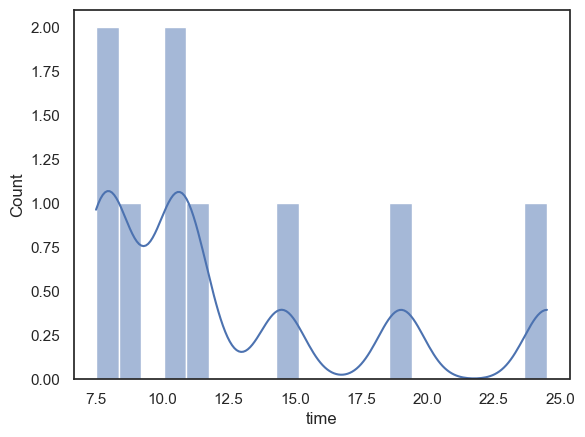

In [56]:
sns.set(style='white')

##first group by platform, get mean, and sort by ascending value
protocol_time = summary_df[['kit', 'time']]
protocol_time = protocol_time.groupby('kit')['time'].mean().sort_values(ascending=True)

##plot histogram with a kde on top
fig, ax = plt.subplots(1,1)
sns.histplot(protocol_time, bins=20, kde=True, kde_kws={'bw_method':0.15}, ax=ax)
plt.show()

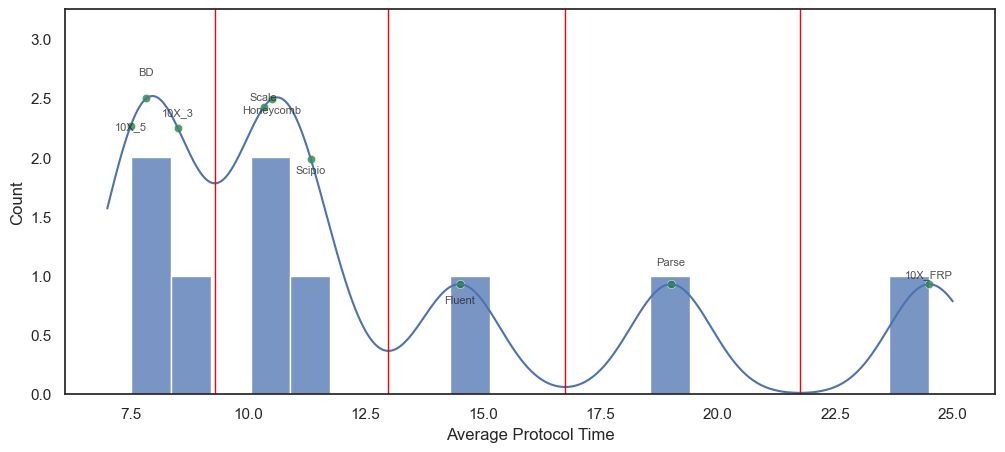

In [57]:
##fit kernel density estimator
bw_method=0.15 ##manually selected to give relatively smooth curve
X_range = np.linspace(7,25, 1000) #X values on range of 7 to 20 based on histogram above
kernel = gaussian_kde(protocol_time, bw_method=bw_method, weights=None) #define kde with bw_method
fitted_dens = kernel.evaluate(X_range) #get density
predicted_dens = kernel.evaluate(protocol_time)
ordered_labels = protocol_time.index

##scale density to get onto scale of histogram
fitted_dens = fitted_dens *18
predicted_dens = predicted_dens*18

 ##Calculate the negative density values so we can find minima by finding peaks of the negative density
neg_dens = -fitted_dens

##Use find_peaks to get estimates for local minima (finds peaks of negative, which are minima in orig)
with ignore_warnings(category=ConvergenceWarning):
    minima_indices, _ = find_peaks(neg_dens)

##get thresholds
protocol_time_thresholds = X_range[minima_indices]

##plot split with points and thresholds
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.plot(X_range, fitted_dens)
sns.histplot(protocol_time, bins=20, ax=ax)
sns.scatterplot(x=protocol_time, y=predicted_dens, color='green',  alpha=0.7, ax=ax)

##Add threshold lines
[ax.axvline(_x, linewidth=1, color="red", linestyle="-") for _x in protocol_time_thresholds]

##Adding labels

np.random.seed(42)
y_jitter = (np.random.rand(len(protocol_time))-0.5)/2.5  # get jitter in range 
for i, txt in enumerate(ordered_labels):
    ax.annotate(txt, ((protocol_time[i]), (predicted_dens[i]+y_jitter[i])), alpha=0.8, ha='center', va='bottom', fontsize=8) ##add vertical jitter
    
##Format Axes
ax.set_xlabel('Average Protocol Time')
ax.set_ylim([None, 3.25])
    
plt.show()

We can get 5 tiers out of this; however, our precision for protocol time is not high enough to go to this granularity. Instead, we will actually create tiers based approximately on the number of work days required where a work day is 8 hours +/- 30 minutes (ie 7.5-8.5). With this strategy, BD, 10X 5', and 10X 3' are one work day; Honeycomb, Scale, Scipio, and Fluent are 2 work days; and Parse and 10X FRP are 3 work days.

In [58]:
# ##get groups now that we have thresholds (lower group if <= higher group if >)
# protocol_time_thresholds = np.sort(protocol_time_thresholds) ##make sure it is ascending so first is lower one
# protocol_time_tiers = { 
#     5: protocol_time[protocol_time > protocol_time_thresholds[3]].index.to_list(),
#     4: protocol_time[(protocol_time > protocol_time_thresholds[2]) & (protocol_time <= protocol_time_thresholds[3])].index.to_list(),
#     3: protocol_time[(protocol_time > protocol_time_thresholds[1]) & (protocol_time <= protocol_time_thresholds[2])].index.to_list(),
#     2: protocol_time[(protocol_time > protocol_time_thresholds[0]) & (protocol_time <= protocol_time_thresholds[1])].index.to_list(),
#     1: protocol_time[protocol_time <= protocol_time_thresholds[0]].index.to_list()
# }
# print('Protocol Time Tiers:')
# protocol_time_dict = {}
# for k, v in protocol_time_tiers.items():
#     for value in v:
#         protocol_time_dict[value] = k

##Based on the number of work days
protocol_time_dict = {'10X_FRP': 3, 'Parse': 3, 
                      'Fluent': 2, 'Scipio': 2, 'Honeycomb': 2, 'Scale': 2,
                      '10X_3': 1, 'BD': 1, '10X_5': 1
                     }
print("Workday based tiers:")    
protocol_time_dict

Workday based tiers:


{'10X_FRP': 3,
 'Parse': 3,
 'Fluent': 2,
 'Scipio': 2,
 'Honeycomb': 2,
 'Scale': 2,
 '10X_3': 1,
 'BD': 1,
 '10X_5': 1}

okay_now let's convert the boolean values into tiers (if True, becomes tier 1, if False becomes tier 2)

In [59]:
summary_df['fixation_tiers'] = [1 if fixation else 2 for fixation in summary_df['fixation']]
summary_df['nuclei_tiers'] = [1 if nuclei else 2 for nuclei in summary_df['nuclei']]
summary_df['FFPE_tiers'] = [1 if FFPE else 2 for FFPE in summary_df['FFPE']]

Okay now we'll add these tiers back to the summary df and drop the original values to get a tiered dataframe

In [61]:
##get tier columns
summary_df['cost_per_cell_tier'] = summary_df['kit'].map(cost_per_cell_dict)
summary_df['equipment_cost_tier'] = summary_df['kit'].map(log1p_equipment_cost_dict)
summary_df['max_cell_recovery_tier'] = summary_df['kit'].map(log1p_max_cell_recovery_dict)
summary_df['protocol_time_tier'] = summary_df['kit'].map(protocol_time_dict)

##subset desire columns
keep_cols = ['kit', 'fixation_tiers', 'nuclei_tiers', 'FFPE_tiers', 'cost_per_cell_tier', 'equipment_cost_tier', 'max_cell_recovery_tier',
       'protocol_time_tier', 'cell_recovery_tier', 'gene_saturation_tier',
       'umi_saturation_tier', 'read_utilization_tier', 'gene_umi_count_tier',
       'mt_fraction_tier', 'rp_fraction_tier', 'gene_stability_tier', 'celltype_dist_tier',
       'cluster_discrim_tier', 'diff_expr_tier']
summary_df_tiers = summary_df[keep_cols]

##set index as kit
summary_df_tiers = summary_df_tiers.set_index('kit')
summary_df_tiers

,fixation_tiers,nuclei_tiers,FFPE_tiers,cost_per_cell_tier,equipment_cost_tier,max_cell_recovery_tier,protocol_time_tier,cell_recovery_tier,gene_saturation_tier,umi_saturation_tier,read_utilization_tier,gene_umi_count_tier,mt_fraction_tier,rp_fraction_tier,gene_stability_tier,celltype_dist_tier,cluster_discrim_tier,diff_expr_tier
kit,,,,,,,,,,,,,,,,,,
10X_3,2,1,2,2,3,2,1,1,2,1,2,1,2,2.0,1,1,1,1
10X_5,2,1,2,2,3,2,1,1,2,2,3,2,2,2.0,1,1,1,2
10X_FRP,1,1,1,2,3,2,3,1,1,1,1,1,1,NaN,1,1,1,1
Fluent,2,1,2,1,2,2,2,1,3,2,3,2,2,2.0,2,3,1,2
BD,2,1,2,1,2,2,1,2,2,1,2,1,3,2.0,1,1,1,2
Honeycomb,2,1,2,1,2,2,2,1,3,2,3,2,2,2.0,2,2,2,3
Parse,1,1,2,1,1,1,3,2,2,2,3,2,1,1.0,1,1,2,2
Scale,1,1,2,1,1,1,2,1,2,2,3,2,1,1.0,2,1,2,2
Scipio,2,2,2,3,1,3,2,1,3,2,3,2,2,2.0,3,2,2,3


Now we can score by category of feature to generate radar plot categories. We have defined the tiers such that 1 is the 'best' and the highest value is the 'worst'. To score per category we will use a normalized proportion ranking system. The formula is as follows:

$$
\text{Category Score} = \frac{{1}}{{n}}\sum_{{i=1}}^{{n}} \left(1-\frac{{\text{{rank}}_i-\text{{low rank}}_i}}{{\text{{high rank}}_i-\text{{low rank}}_i}}\right)
$$

where the high rank is the highest tier value (ie if 3 tiers, this would be 3) and low rank would be the lowest tier value (always 1 for our system). We subtract from 1 because the "low rank" is actually the best performer (ie tier 1 is the best). We average over the number of features ($n$) present for a given category so we can get the overall category score

In [62]:
##break into categories of interest (some/most will be alone)
cost_per_cell_cat=['cost_per_cell_tier']
equip_cost_cat=['equipment_cost_tier']
time_cat=['protocol_time_tier']
max_cell_recovery_cat=['max_cell_recovery_tier']
cell_recovery_cat=['cell_recovery_tier'] 
read_util_cat=['read_utilization_tier']
gene_umi_sen = ['gene_saturation_tier', 'umi_saturation_tier']
mt_cat=['mt_fraction_tier']
rp_cat=['rp_fraction_tier']
gene_stability_cat=['gene_stability_tier']
celltype_dist_cat=['celltype_dist_tier']
cluster_discrim_cat=['cluster_discrim_tier']
dge_cat=['diff_expr_tier']

In [63]:
def normalized_rank(feature_data, high_rank, low_rank=1):
    
    ##get the normalize rank for each observation in a given feature where 1 is the best performer and 0 is the worst
    if isinstance(feature_data, bool):
        feature_data = feature_data * 1
    return [1 - (rank - low_rank) / (high_rank - low_rank) for rank in feature_data]

def cat_score(df, feature_list):
    
    ##get the normalized scores across all categories
    norm_scores = df.loc[:, feature_list].apply(lambda x: normalized_rank(feature_data=x, high_rank=np.max(x), low_rank=1), axis=0)
    
    ##get the mean per observation across all categories (do NOT ignore NaN) and return
    score = norm_scores.mean(axis = 1, skipna=False)
    score.index = df.index
    
    return score

In [64]:
##Make dictionary for all categories and featuers
summary_cat_dict = {'Cost\n(per Cell)': cost_per_cell_cat, 'Cost\n(Equipment)':equip_cost_cat, 
                    'Time': time_cat, 
                    'Cell Recovery\n(% of Target)': cell_recovery_cat, 'Max Cell\nRecovery': max_cell_recovery_cat,
                    'Read Utilization': read_util_cat,
                    'Gene & UMI\nSensitivity': gene_umi_sen, 
                    'Mito QC': mt_cat,#'Ribo QC': rp_cat, 
                    'Gene Expression\nStability': gene_stability_cat,
                    'CyTOF\nSimilarity': celltype_dist_cat, 'Cluster\nDiscrimination': cluster_discrim_cat, "DGE": dge_cat
                   }

##get scores across categories
summary_cat_scores = {}
for cat, feature_list in summary_cat_dict.items():
    summary_cat_scores[cat] = cat_score(summary_df_tiers, feature_list)
    
summary_cat_scores = pd.DataFrame(summary_cat_scores)
summary_cat_scores

,Cost\n(per Cell),Cost\n(Equipment),Time,Cell Recovery\n(% of Target),Max Cell\nRecovery,Read Utilization,Gene & UMI\nSensitivity,Mito QC,Gene Expression\nStability,CyTOF\nSimilarity,Cluster\nDiscrimination,DGE
kit,,,,,,,,,,,,
10X_3,0.5,0.0,1.0,1.0,0.5,0.5,0.75,0.5,1.0,1.0,1.0,1.0
10X_5,0.5,0.0,1.0,1.0,0.5,0.0,0.25,0.5,1.0,1.0,1.0,0.5
10X_FRP,0.5,0.0,0.0,1.0,0.5,1.0,1.00,1.0,1.0,1.0,1.0,1.0
Fluent,1.0,0.5,0.5,1.0,0.5,0.0,0.00,0.5,0.5,0.0,1.0,0.5
BD,1.0,0.5,1.0,0.0,0.5,0.5,0.75,0.0,1.0,1.0,1.0,0.5
Honeycomb,1.0,0.5,0.5,1.0,0.5,0.0,0.00,0.5,0.5,0.5,0.0,0.0
Parse,1.0,1.0,0.0,0.0,1.0,0.0,0.25,1.0,1.0,1.0,0.0,0.5
Scale,1.0,1.0,0.5,1.0,1.0,0.0,0.25,1.0,0.5,1.0,0.0,0.5
Scipio,0.0,1.0,0.5,1.0,0.0,0.0,0.00,0.5,0.0,0.5,0.0,0.0


Now let's make the radar plots to visualize these summary metrics (adapted from documentation: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html)

In [65]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

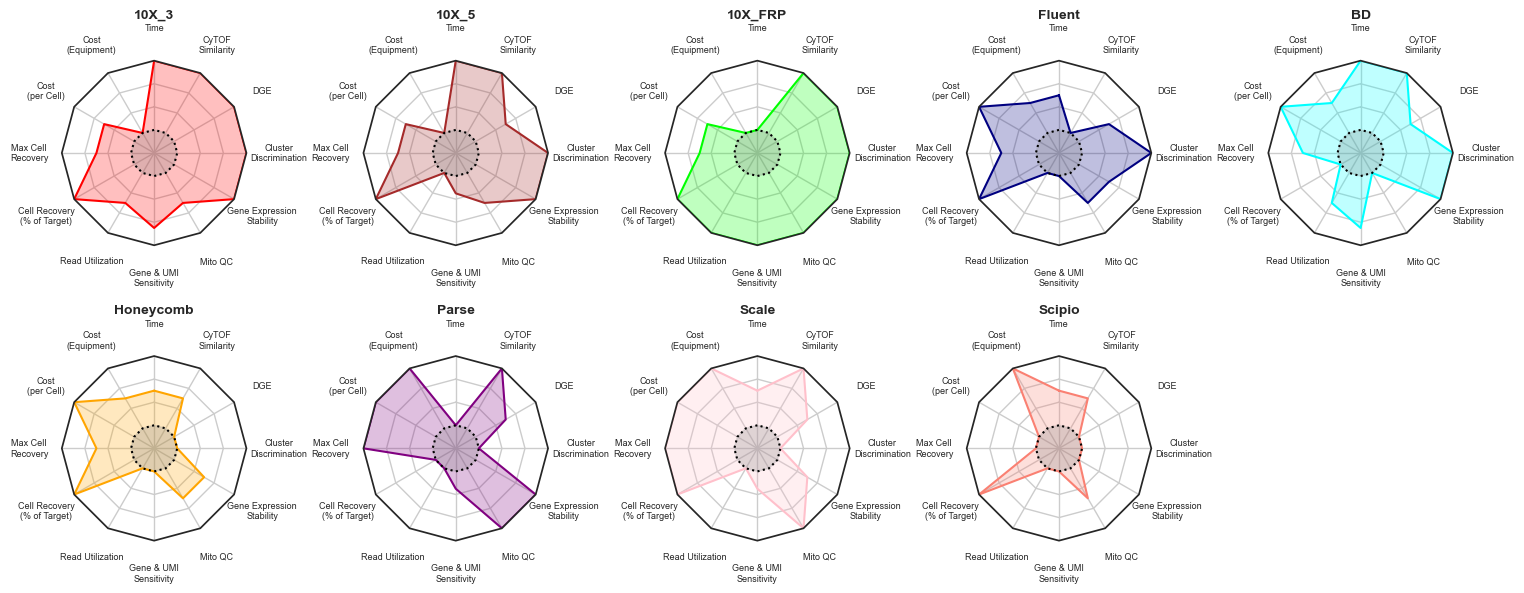

In [69]:
##Let's format data and get ready for plotting
N = summary_cat_scores.shape[1]
colors_platform = {'10X_3':'red', 
                   '10X_5':'brown', 
                   '10X_FRP':'lime',
                   'BD':'cyan', 
                   'Fluent':'navy', 
                   'Honeycomb':'orange', 
                   'Parse':'purple', 
                   'Scale':'pink', 
                   'Scipio':'salmon', 
                   'Singleron':'gold'
                  }
##change spoke label ordering
cat_order = ['Time', 'Cost\n(Equipment)', 'Cost\n(per Cell)', 
             'Max Cell\nRecovery', 'Cell Recovery\n(% of Target)', 'Read Utilization',  
             'Gene & UMI\nSensitivity', 'Mito QC', 'Gene Expression\nStability', #'Ribo QC', 
             'Cluster\nDiscrimination', 'DGE', 'CyTOF\nSimilarity']
summary_cat_scores = summary_cat_scores.loc[:, cat_order]


##get angle on the polar plot
theta = radar_factory(N, frame='polygon')
spoke_labels = summary_cat_scores.columns ##get category titles

fig, axs = plt.subplots(figsize=(18,6), nrows=2, ncols=5,
                        subplot_kw=dict(projection='radar'), sharey=True)
fig.subplots_adjust(wspace=0.6, hspace=0.6, top=0.85, bottom=0.05)

## Remove the last subplot (2nd row, 5th column) since we only have 9 kits
fig.delaxes(axs[1, 4])

##plot kits separately (so we need to transpose data)
for ax, (kit, cat_data) in zip(axs.flat, summary_cat_scores.T.items()):
    
    ##format grid and title
    # ax.set_rgrids([1/3, 2/3, 1]) ##radius grids
    ax.set_rgrids([1/3, 2/3, 1]) # grid lines
    ax.set_yticklabels([]) ##remove grid labels
    ax.set_title(kit, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center', fontsize=10) ##set kit as title
    
    ##shift categorical data by 0.33 so that the smallest value is at the first ring instead of the middle
    shift_amount=1/3
    cat_data=cat_data+shift_amount
    
    ##Fill singleron NaN values with a number below the number that represents zero for us (shift_amount)
    if kit == 'Singleron':
        cat_data = np.nan_to_num(cat_data, nan=0.17)

    ##plot data with colors
    ax.plot(theta, cat_data, color=colors_platform[kit]) ##get radar plot
    ax.set_varlabels(spoke_labels)
    ax.fill(theta, cat_data, facecolor=colors_platform[kit], alpha=0.25, label='_nolegend_') ##add fill with transparency
    
    ##add artificial grid line
    r_values = np.ones_like(theta) * shift_amount # radial distance
    ax.plot(theta, r_values, ':', linewidth=1.5, color='black') # plot 'artificial' gridline
    
    ##overlay grey circle to indicate NA
    ax.fill(theta, r_values, facecolor="grey", alpha=0.25, label='_nolegend_') ##add fill with transparency

    ##change axis fontsizes
    plt.setp(ax.get_xticklabels(), fontsize=6.5)
    plt.setp(ax.get_yticklabels(), fontsize=8)

    ##Add padding for the spoke labels
    ax.tick_params(axis='x', which='major', pad=10.5)

    ##set y_lim to always start at 0 and end at shift value
    ax.set_ylim([0,1+shift_amount])
        
plt.show()

Make Radial Legend

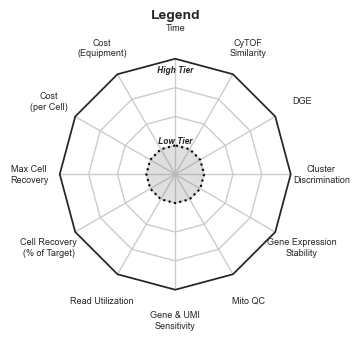

In [68]:
##setup legend plot
fig, ax = plt.subplots(figsize=(3,3), nrows=1, ncols=1,
                        subplot_kw=dict(projection='radar'), sharey=True)


##make legend plot
##format grid and title
ax.set_rlabel_position(0)  # Set placement of radius labels.
ax.set_rgrids([1/3, 2/3, 3/3, 4/3]) # grid lines
ax.set_yticklabels([]) ##remove grid labels
ax.text(np.radians(0), 1/3 + 0.05, "Low Tier", weight='bold', style='italic', ha='center', va='center', fontsize=6)
ax.text(np.radians(0), 4/3 - 0.125, "High Tier", weight='bold', style='italic', ha='center', va='center', fontsize=6)
ax.set_title("Legend", weight='bold', size='medium', position=(0.5, 1.1),
             horizontalalignment='center', verticalalignment='center', fontsize=10) ##set kit as title

##shift categorical data by 0.33 so that the smallest value is at the first ring instead of the middle
shift_amount=1/3

##plot spoke labels
ax.set_varlabels(spoke_labels)

##add artificial grid line
r_values = np.ones_like(theta) * shift_amount # radial distance
ax.plot(theta, r_values, ':', linewidth=1.5, color='black') # plot 'artificial' gridline
ax.fill(theta, r_values, facecolor="grey", alpha=0.25, label='_nolegend_') ##add fill with transparency

##change axis fontsizes
plt.setp(ax.get_xticklabels(), fontsize=6.5)
plt.setp(ax.get_yticklabels(), fontsize=10.5)

##Add padding for the spoke labels
ax.tick_params(axis='x', which='major', pad=9)

##set y_lim to always start at 0 and end at shift value
ax.set_ylim([0,4/3])
        
plt.show()